# **Golf Swing Sequencing Analysis (2023 Revised)**
by Karit Sookpreedee

**Part 1**

This part requires `Pytorch`.

*The objectives of this part are:*
1. Resize the video resolution for pro’s video and newbie’s video to 256*256
2. Use SwingNet to predict 8 golf swing event frames and extract those frames

Your pro’s and newbie’s videos should be in the `Input` folder, which should be in the exact location as this .ipynb file.

All outputs from this part will be inside the `Output` folder.

<img src="./Information/Deep Learning Based Golf Swing Sequencing Analysis Program Overview.png" alt="PNG Image" />


# Import libraries

In [1]:
import argparse
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
from eval import ToTensor, Normalize
from model import EventDetector
import numpy as np
import torch.nn.functional as F
import math
import os
import os.path as osp
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
from PIL import Image

# Define functions

In [2]:
event_names = {
    0: 'Address',
    1: 'Toe-up',
    2: 'Mid-backswing (arm parallel)',
    3: 'Top',
    4: 'Mid-downswing (arm parallel)',
    5: 'Impact',
    6: 'Mid-follow-through (shaft parallel)',
    7: 'Finish'
}

class SampleVideo(Dataset):
    def __init__(self, path, input_size=160, transform=None):
        self.path = path
        self.input_size = input_size
        self.transform = transform

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        cap = cv2.VideoCapture(self.path)
        frame_size = [cap.get(cv2.CAP_PROP_FRAME_HEIGHT), cap.get(cv2.CAP_PROP_FRAME_WIDTH)]
        ratio = self.input_size / max(frame_size)
        new_size = tuple([int(x * ratio) for x in frame_size])
        delta_w = self.input_size - new_size[1]
        delta_h = self.input_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # preprocess and return frames
        images = []
        for pos in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            _, img = cap.read()
            resized = cv2.resize(img, (new_size[1], new_size[0]))
            b_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                       value=[0.406 * 255, 0.456 * 255, 0.485 * 255])  # ImageNet means (BGR)

            b_img_rgb = cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB)
            images.append(b_img_rgb)
        cap.release()
        labels = np.zeros(len(images)) # only for compatibility with transforms
        sample = {'images': np.asarray(images), 'labels': np.asarray(labels)}
        if self.transform:
            sample = self.transform(sample)
        return sample


def resize_video(input_video_path, output_folder, output_width, output_height):
    """
    Resizes a video to the specified dimensions, adding black space to maintain the aspect ratio,
    and saves it to the specified output folder.

    Parameters:
        input_video_path (str): Path to the input video file.
        output_folder (str): Folder to save the resized video file.
        output_width (int): The desired width of the output video.
        output_height (int): The desired height of the output video.

    Returns:
        str: The path to the saved resized video.
    """
    
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create the output video path
    input_filename = os.path.basename(input_video_path)
    output_video_path = os.path.join(output_folder, f"resized_{input_filename}")
    
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)
    
    # Get the properties of the input video
    input_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    input_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate aspect ratios
    input_aspect_ratio = input_width / input_height
    output_aspect_ratio = output_width / output_height
    
    # Determine the new size preserving the aspect ratio
    if input_aspect_ratio > output_aspect_ratio:
        new_width = output_width
        new_height = int(output_width / input_aspect_ratio)
    else:
        new_height = output_height
        new_width = int(output_height * input_aspect_ratio)
    
    # Calculate padding to center the resized frame
    pad_top = (output_height - new_height) // 2
    pad_bottom = output_height - new_height - pad_top
    pad_left = (output_width - new_width) // 2
    pad_right = output_width - new_width - pad_left
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (output_width, output_height))
    
    # Process each frame
    for _ in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize the frame
        resized_frame = cv2.resize(frame, (new_width, new_height))
        
        # Add padding
        padded_frame = cv2.copyMakeBorder(resized_frame, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        
        # Write the frame to the output video
        out.write(padded_frame)
    
    # Release the video objects
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    return output_video_path

    
def swingnet(video_path,model_path):

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the total number of frames
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    video.release()

    print(f'The number of frames in the video is: {frame_count}')

    ds = SampleVideo(video_path, transform=transforms.Compose([ToTensor(),
                                Normalize([0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])]))

    dl = DataLoader(ds, batch_size=1, shuffle=False, drop_last=False)

    model = EventDetector(pretrain=True,
                            width_mult=1.,
                            lstm_layers=1,
                            lstm_hidden=256,
                            bidirectional=True,
                            dropout=False)

    try:
        save_dict = torch.load(model_path, map_location={'cuda:0': 'cpu'})
    except:
        print("Model weights not found. Download model weights and place in 'models' folder. See README for instructions")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    model.load_state_dict(save_dict['model_state_dict'])
    model.to(device)
    model.eval()
    print("Loaded model weights")
    print('Testing...')

    for sample in dl:
        images = sample['images']
        batch = 0
        while batch * frame_count < images.shape[1]:
            if (batch + 1) * frame_count > images.shape[1]:
                image_batch = images[:, batch * frame_count:, :, :, :]
            else:
                image_batch = images[:, batch * frame_count:(batch + 1) * frame_count, :, :, :]
            logits = model(image_batch)
            if batch == 0:
                probs = F.softmax(logits.data, dim=1).cpu().numpy()
            else:
                probs = np.append(probs, F.softmax(logits.data, dim=1).cpu().numpy(), 0)
            batch += 1

    events = np.argmax(probs, axis=0)[:-1]
    print('Predicted event frames: {}'.format(events))
    cap = cv2.VideoCapture(video_path)

    Probability = []
    for i, e in enumerate(events):
        Probability.append(probs[e, i])
    print('Probability: {}'.format([np.round(c, 3) for c in Probability]))

    print("------------------------------------------------------------------------------------------------------------------")

    # for i, e in enumerate(events):
    #     cap.set(cv2.CAP_PROP_POS_FRAMES, e)
    #     _, img = cap.read()
    #     cv2.putText(img, '{:.3f}'.format(confidence[i]), (20, 20), cv2.FONT_HERSHEY_DUPLEX, 0.75, (0, 0, 255))
    #     cv2.imshow(event_names[i], img)
    #     cv2.waitKey(0)
    #     cv2.destroyAllWindows()
    
    return list(events)

def extract_and_crop_frames(video_path, frame_numbers_list, destination_folder):
    # Create destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Extract frames
    for e in range(len(frame_numbers_list)):
        # Check if frame number is valid
        if frame_numbers_list[e] < total_frames:
            # Set frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_numbers_list[e])
            # Read the frame
            ret, frame = cap.read()
            if ret:
                # Annotate frame number
                font = cv2.FONT_HERSHEY_SIMPLEX
                position_1 = (10, 20)
                position_2 = (10, 236)
                font_scale = 0.4
                font_color = (255, 255, 0)
                thickness = 1
                cv2.putText(frame, f"Frame {frame_numbers_list[e]}", position_1, font, font_scale, font_color, thickness)
                cv2.putText(frame, event_names[e], position_2, font, font_scale, font_color, thickness)

                # Write cropped frame to destination folder
                frame_path = os.path.join(destination_folder, f"frame_{e}.jpg")
                cv2.imwrite(frame_path, frame)
                print(f"Frame {frame_numbers_list[e]} extracted and cropped successfully to {frame_path}")
            else:
                print(f"Error extracting frame {frame_numbers_list[e]}")
        else:
            print(f"Frame number {frame_numbers_list[e]} is out of range")

    # Release the video capture object
    cap.release()

def plot_images_from_folders(folder1, folder2):

    # Get list of image paths
    images_folder1 = [os.path.join(folder1, f) for f in sorted(os.listdir(folder1)) if f.endswith(('.png', '.jpg', '.jpeg'))]
    images_folder2 = [os.path.join(folder2, f) for f in sorted(os.listdir(folder2)) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure both folders have 8 images
    assert len(images_folder1) == 8, "Folder 1 does not contain exactly 8 images."
    assert len(images_folder2) == 8, "Folder 2 does not contain exactly 8 images."

    # Create subplots
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 50))

    # Plot images
    for i in range(8):
        # Load images
        img1 = Image.open(images_folder1[i])
        img2 = Image.open(images_folder2[i])
        
        # Display images
        axes[i, 0].imshow(img1)
        axes[i, 1].imshow(img2)
        
        # Remove axes for a cleaner look
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    plt.show()

# Inputs

In [3]:
pro_video_path = "Inputs/pro.mp4"
newbie_video_path = "Inputs/newbie.mp4"
Outputs_folder_path = "Outputs"
model_path = "swingnet_1800.pth.tar"

# Resize videos

In [4]:
pro_video_resized_path = resize_video(pro_video_path, Outputs_folder_path, 256, 256)
newbie_video_resized_path = resize_video(newbie_video_path, Outputs_folder_path, 256, 256)

# SwingNet: Get predicted 8 event frames

<img src="./Information/SwingNet_Algorithm.png" alt="PNG Image" width="700"/>

For example:

`Predicted event frames: [19 29 32 35 39 43 45 68]`

`Probability: [0.027, 0.381, 0.94, 0.799, 0.94, 0.972, 0.993, 0.222]`

For this video, event 2 (Mid-backswing) occurs at frame 32 with a probability of 0.94.

<img src="./Information/8events.png" alt="PNG Image" width="1000"/>

In [5]:
pro_event_list = swingnet(pro_video_resized_path,model_path)
newbie_event_list = swingnet(newbie_video_resized_path,model_path)

The number of frames in the video is: 117
Using device: cpu
Loaded model weights
Testing...
Predicted event frames: [19 29 32 35 39 43 45 68]
Probability: [0.027, 0.381, 0.94, 0.799, 0.94, 0.972, 0.993, 0.222]
------------------------------------------------------------------------------------------------------------------
The number of frames in the video is: 143
Using device: cpu
Loaded model weights
Testing...
Predicted event frames: [ 65  69  73  90 105 112 115 139]
Probability: [0.003, 0.322, 0.816, 0.417, 0.98, 0.975, 0.933, 0.163]
------------------------------------------------------------------------------------------------------------------


# Extract and crop frame

In [6]:
destination_folder_pro = "Outputs/8frames_pro"
extract_and_crop_frames(pro_video_resized_path, pro_event_list, destination_folder_pro)

Frame 19 extracted and cropped successfully to Outputs/8frames_pro/frame_0.jpg
Frame 29 extracted and cropped successfully to Outputs/8frames_pro/frame_1.jpg
Frame 32 extracted and cropped successfully to Outputs/8frames_pro/frame_2.jpg
Frame 35 extracted and cropped successfully to Outputs/8frames_pro/frame_3.jpg
Frame 39 extracted and cropped successfully to Outputs/8frames_pro/frame_4.jpg
Frame 43 extracted and cropped successfully to Outputs/8frames_pro/frame_5.jpg
Frame 45 extracted and cropped successfully to Outputs/8frames_pro/frame_6.jpg
Frame 68 extracted and cropped successfully to Outputs/8frames_pro/frame_7.jpg


In [7]:
destination_folder_newbie = "Outputs/8frames_newbie"
extract_and_crop_frames(newbie_video_resized_path, newbie_event_list, destination_folder_newbie)

Frame 65 extracted and cropped successfully to Outputs/8frames_newbie/frame_0.jpg
Frame 69 extracted and cropped successfully to Outputs/8frames_newbie/frame_1.jpg
Frame 73 extracted and cropped successfully to Outputs/8frames_newbie/frame_2.jpg
Frame 90 extracted and cropped successfully to Outputs/8frames_newbie/frame_3.jpg
Frame 105 extracted and cropped successfully to Outputs/8frames_newbie/frame_4.jpg
Frame 112 extracted and cropped successfully to Outputs/8frames_newbie/frame_5.jpg
Frame 115 extracted and cropped successfully to Outputs/8frames_newbie/frame_6.jpg
Frame 139 extracted and cropped successfully to Outputs/8frames_newbie/frame_7.jpg


# Comparison

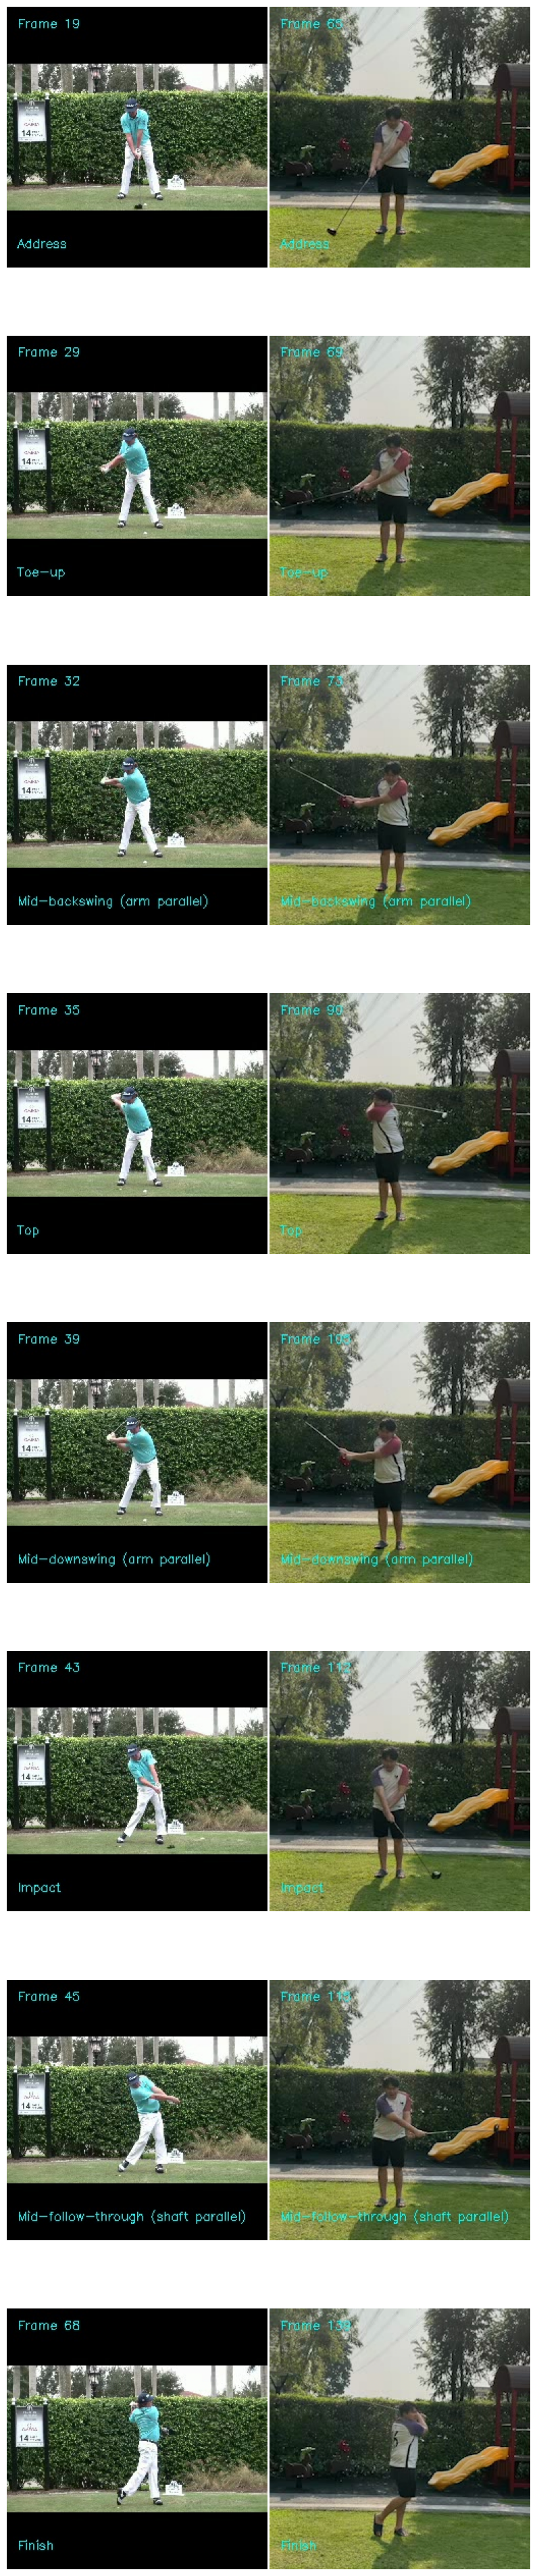

In [8]:
plot_images_from_folders(destination_folder_pro, destination_folder_newbie)

*Modified from:* GolfDB: A Video Database for Golf Swing Sequencing

The code in this repository is licensed under a [Creative Commons Attribution-NonCommercial 4.0 International License](https://creativecommons.org/licenses/by-nc/4.0/). 

GolfDB is a high-quality video dataset created for general recognition applications 
in the sport of golf, and specifically for the task of golf swing sequencing. 

GolfDB paper:
```
@InProceedings{McNally_2019_CVPR_Workshops,
author = {McNally, William and Vats, Kanav and Pinto, Tyler and Dulhanty, Chris and McPhee, John and Wong, Alexander},
title = {GolfDB: A Video Database for Golf Swing Sequencing},
booktitle = {The IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops},
month = {June},
year = {2019}
}
```

# **Modified by Karit Sookpreedee (May 2023)**